In [14]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.signal import oaconvolve
from scipy.signal import remez
import time
import decimate as d
from importlib import reload
reload(d);

In [4]:
time.perf_counter()

36884.366708138

In [5]:
f3 = remez(2002,[0., 1, 2., 250.],[1.,0.],fs=500)
f3 = f3[1:-1]

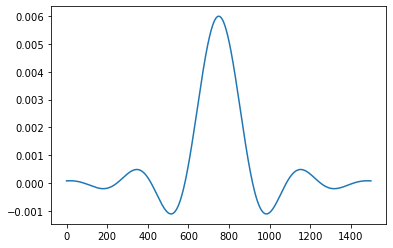

In [6]:
plt.plot(f3[250:1750])

In [7]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")

In [8]:
con = engine.connect()

```SQL
create table interpolation_types (
	id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT,
    interp_algo varchar(45),
    algo_version varchar(20),
    notebook_name varchar(45),
    sampling_rate float(6,4)
    )
```

In [13]:

stmnt ="""
INSERT IGNORE INTO interpolation_series
values 
    (1, "legacy", "", NULL, 0.5),
    (2, "piecewise", "ec31c78", "interpolate and upload", 0.5),
    (3, "piecewise", "716f804", "interpolate and upload", 0.5),
    (4, "piecewise", "716f804", "interpolate and upload", 0.25)

"""

con.execute(stmnt)

/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '1' for key 'PRIMARY'")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '2' for key 'PRIMARY'")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1062, "Duplicate entry '3' for key 'PRIMARY'")
  result = self._query(query)


In [9]:
stmnt = """
SELECT DISTINCT series_type_id, group_id, participant_id
FROM raw_interval_data
"""

raw_series = con.execute(stmnt)

In [10]:
raw_series

In [11]:
get_series = sql.text("""
SELECT data_time
FROM raw_interval_data
WHERE series_type_id = :sti
AND group_id = :gi
AND participant_id = :pi""")

In [25]:
tref = time.perf_counter()
#for series_type_id, group_id, participant_id in raw_series:
series_type_id=3
participant_id = 119
group_id = 1007
print(series_type_id, group_id, participant_id, np.around(time.perf_counter()-tref,2) ) 
q = con.execute(get_series, sti=series_type_id, gi= group_id, pi=participant_id)
t = np.array(q.fetchall()).astype(float).squeeze()
x = t[:-1] # don't use the point which marks the end of the experiment
y = np.diff(x)
x_pw = np.arange(0,t[-1],0.25)
y_pw = d.pw_constant_convolve(x[:-1], y, t[-1], f3, 2, 1.5, x_pw)
nx = len(x_pw)
interpolated_data = pd.DataFrame({
    'series_type_id': [series_type_id]*nx,
    'interpolation_series_id': [4]*nx,
    'group_id': [group_id]*nx,
    'participant_id': [participant_id]*nx,
    'data_ordinal': range(nx),
    'data_time': x_pw,
    'data_value': np.around(y_pw,5)
})
#    interpolated_data.to_sql(name='interpolated_interval_data', con=con, if_exists='append', index=False, method='multi')   


3 1007 119 0.0


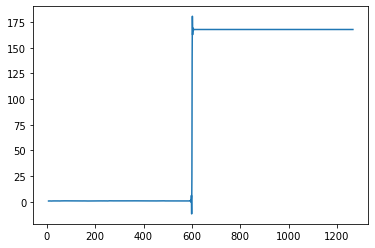

In [21]:
plt.plot(y_pw)

In [ ]:
y_pw = d.pw_constant_convolve(x, y, t[-1], f3, 4, 3, x_pw)
nx = len(x_pw)
interpolated_data = pd.DataFrame({
    'series_type_id': [series_type_id]*nx,
    'group_id': [group_id]*nx,
    'participant_id': [participant_id]*nx,
    'data_ordinal': range(nx),
    'data_time': x_pw,
    'data_value': np.around(y_pw,5)
})
interpolated_data.to_sql(name='interpolated_interval_data', con=con, if_exists='append', index=False, method='multi')   


In [ ]:
df

In [ ]:
(t[-1], f3, 4, 3, x_pw)

In [ ]:
x

In [ ]:
y